In [1]:
# Quality Check

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('HR_comma_sep.csv')

print("SUM OF MISSING VALUES IN DATAFRAME")
print(df.isna().sum())
num_df = df.drop(['sales', 'salary'], axis=1)

SUM OF MISSING VALUES IN DATAFRAME
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


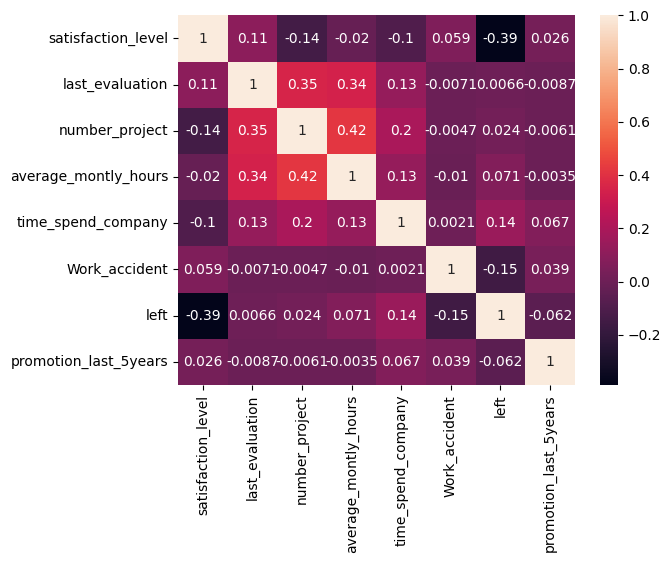

In [2]:
# Investigating factors of employee turnover

# Correlation Matrix Heatmap
sns.heatmap(num_df.corr(), annot=True)
plt.show()

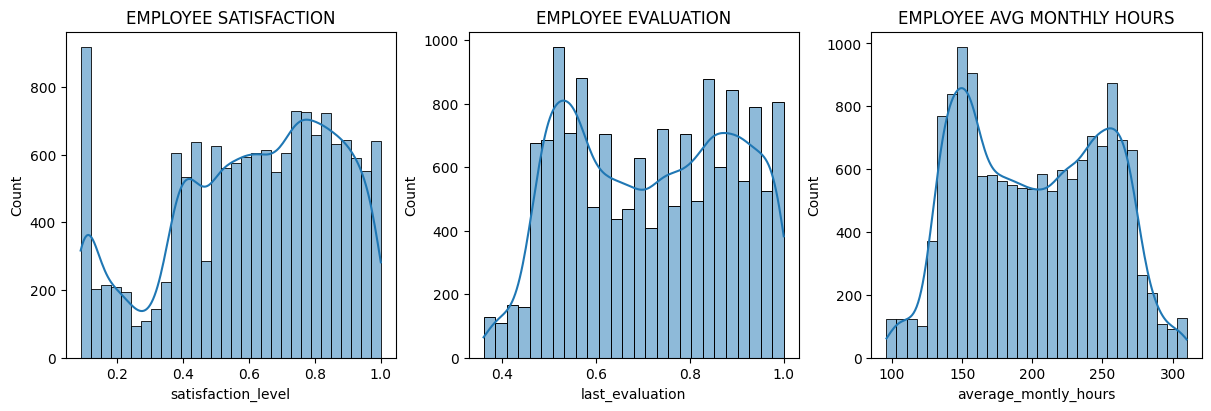

In [3]:
# Distribution Plot

fig, axs = plt.subplots(ncols=3, figsize=(12,4), layout='constrained')

# Employee Satisfaction
ax0 = sns.histplot(df['satisfaction_level'], kde=True, ax=axs[0])
ax0.set_title("EMPLOYEE SATISFACTION")

#  Employee Evaluation
ax1 = sns.histplot(df['last_evaluation'], kde=True, ax=axs[1])
ax1.set_title("EMPLOYEE EVALUATION")

# Employee Avg. Hours in a Month
ax2 = sns.histplot(df['average_montly_hours'], kde=True, ax=axs[2])
ax2.set_title("EMPLOYEE AVG MONTHLY HOURS")

plt.show()

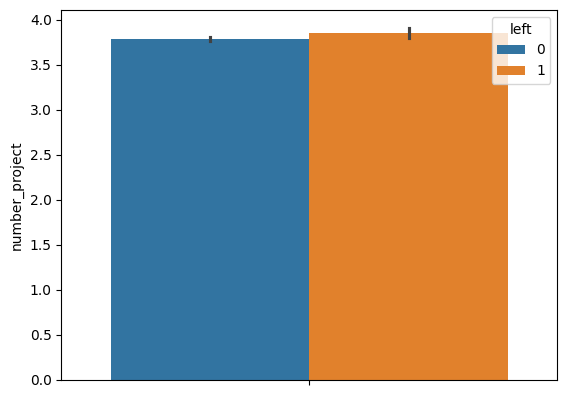

In [4]:
# Employee Project Count & Leave Status
sns.barplot(data=df, y='number_project', hue='left')
plt.show()

1. Correlation on employee turnover - i.e., employees who have left - is strongest in relation to satisfaction level, the time spent in the company, and whether the employee had suffered from a work accident.
2. A concerningly high number of employees appear to have an overwhelmingly low satisfaction level, which will require further investigation in terms of turnover. 
3. There appears to be little correlation with the number of projects and their leave status, as evidenced by the correlation matrix & the barplot.

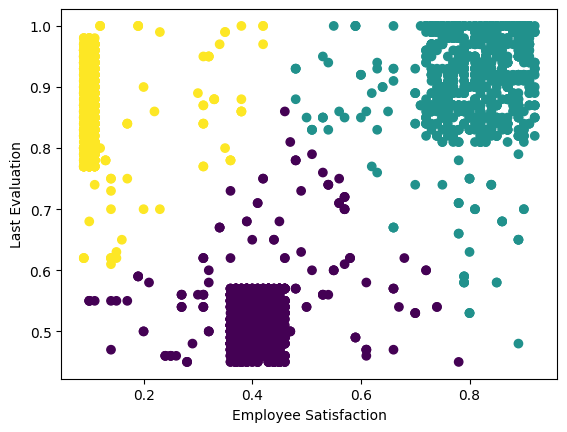

y_kmeans
0    1650
1     977
2     944
Name: count, dtype: int64
          satisfaction_level  last_evaluation
y_kmeans                                     
0                   0.410145         0.516982
1                   0.808516         0.911709
2                   0.111155         0.869301


In [5]:
# Clustering based off employee satisfaction & evaluation score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# DEBUG: Should print the columns satisfaction_level, last_evaluation, and left
# print(df.iloc[:, [0, 1, 6]].head(10))
X_kmeans = df.iloc[:, [0, 1, 6]]
X_kmeans = X_kmeans[X_kmeans['left'] == 1]      # Filtering out employees who stayed
model = KMeans(n_clusters=3, init="k-means++")
X_kmeans['y_kmeans'] = model.fit_predict(X_kmeans)

plt.scatter(x=X_kmeans['satisfaction_level'], y=X_kmeans['last_evaluation'], c=X_kmeans['y_kmeans'])
plt.xlabel('Employee Satisfaction')
plt.ylabel('Last Evaluation')
plt.show()

print(X_kmeans['y_kmeans'].value_counts().sort_index())
print(X_kmeans.groupby(['y_kmeans'])[['satisfaction_level', 'last_evaluation']].mean())

Based on the clusters, most employees who have left have a low satisfaction & evaluation score (cluster 0) - self-explanatory.

The other two clusters have similar high evaluation scores, but show great disparity in satisfaction levels.

Cluster 1 shows a high satisfaction, this may be a retirement leave or perhaps a leave to a higher company.
Cluster 2 shows a low satisfaction, this may be due to overworking or a stagnation in their role in the company despite adequate performance.

In [6]:
# Handling "left" class imbalance

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

print("# Employees Who Left")
print("0 - Not left")
print("1 - Left")
print("\nBEFORE")
# Notice there is a large imbalance between those who have and haven't left
print(df['left'].value_counts())

# Preprocess categorical variables to numerical
df_cat = df[['Work_accident', 'sales', 'salary']]
df_cat = pd.get_dummies(df_cat, drop_first=True).astype(int)

# Recombining the categorical & numerical variables
X = df.drop(['left', 'Work_accident', 'sales', 'salary'], axis=1)
X = pd.concat([X, df_cat], axis=1)
y = df['left']

# Splitting data before SMOTE?
X_train_MAIN, X_test_MAIN, y_train_MAIN, y_test_MAIN = train_test_split(X, y, train_size=0.8, random_state=123)

# SMOTE
X_new, y_new = SMOTE().fit_resample(X_train_MAIN, y_train_MAIN)

print("\nAFTER")
print(y_new.value_counts())

# Employees Who Left
0 - Not left
1 - Left

BEFORE
left
0    11428
1     3571
Name: count, dtype: int64

AFTER
left
0    9137
1    9137
Name: count, dtype: int64


In [7]:
# 5-Fold cross validation & evaluation

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, accuracy_score

kf = KFold(n_splits=5, shuffle=True)

# Model dictionary with tuple of model title & model itself.
model_dict = {0 : ("Logistic Regression", LogisticRegression(solver="liblinear")),
              1 : ("Random Forest Classifier", RandomForestClassifier()),
              2 : ("Gradient Boosting Classifier", GradientBoostingClassifier())}

# List for future task of plotting
proba_list = []
y_list = []
pred_list = []

for i in range(0, 3):
    model = model_dict[i][1]

    print(model_dict[i][0])

    # print("Accuracy Score:")
    for train_ind, test_ind in kf.split(X_new):
        X_train, X_test = X_new.iloc[train_ind], X_new.iloc[test_ind]
        y_train, y_test = y_new.iloc[train_ind], y_new.iloc[test_ind]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # DEBUG: Accuracy Score to track performance
        # print(accuracy_score(y_test, y_pred))

        proba = model.predict_proba(X_test)
    
    # Appending values to respective lists
    proba_list.append(proba[:, 1])  # Positives
    y_list.append(y_test)
    pred_list.append(y_pred)
   
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1798
           1       0.78      0.78      0.78      1856

    accuracy                           0.78      3654
   macro avg       0.78      0.78      0.78      3654
weighted avg       0.78      0.78      0.78      3654

Random Forest Classifier
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1816
           1       0.99      0.97      0.98      1838

    accuracy                           0.98      3654
   macro avg       0.98      0.98      0.98      3654
weighted avg       0.98      0.98      0.98      3654

Gradient Boosting Classifier
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1842
           1       0.97      0.95      0.96      1812

    accuracy                           

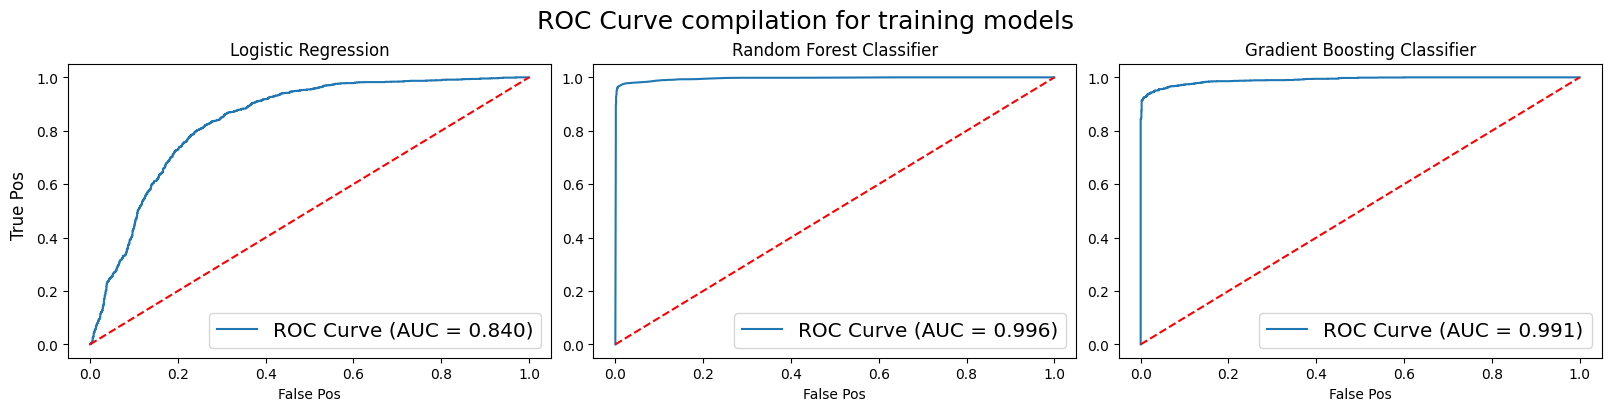

In [8]:
# AUC-ROC score & plot

from sklearn.metrics import roc_auc_score, roc_curve

fig, axs = plt.subplots(ncols=3, figsize=(16,4), layout='constrained')
fig.suptitle("ROC Curve compilation for training models", fontsize=18)
fig.supylabel("True Pos")

# List for determining best model (highest AUC score in this case)
auc_list = []

for i in range(0, 3):
    # Plotting roc curve of each model
    fpr, tpr, thresholds = roc_curve(y_list[i], proba_list[i])
    roc_auc = roc_auc_score(y_list[i], proba_list[i])

    auc_list.append(roc_auc)

    axs[i].set_title(model_dict[i][0])
    axs[i].set_xlabel("False Pos")
    axs[i].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axs[i].plot([0, 1], [0, 1], 'r--')
    axs[i].legend(loc="lower right", fontsize="x-large")

plt.show()

In [9]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

for i in range(0, 3):
    print(f"{model_dict[i][0]} Confusion Matrix")
    print(f"{confusion_matrix(y_list[i], pred_list[i])}\n")

Logistic Regression Confusion Matrix
[[1386  412]
 [ 407 1449]]

Random Forest Classifier Confusion Matrix
[[1805   11]
 [  64 1774]]

Gradient Boosting Classifier Confusion Matrix
[[1789   53]
 [  97 1715]]



Given the context of evaluating employee turnovers, the precision metric should have higher priority since the employees retained who have been identified as a false positive can be remedied in their probability in leaving. False negatives - however, have already left and cannot be remedied to increase their likeliness to stay.

Furthermore, the classification models - i.e., the last 2 models - show an oustanding amount of False Positives relative to False Negative errors, which may provide richer information.

In [10]:
# Probability prediction via best performing model

ind = auc_list.index(max(auc_list))

# DEBUG: Printing the index of the model with the highest AUC score
# print(ind)

# Receiving probability employee will leave
proba_leave = model_dict[ind][1].predict_proba(X_test_MAIN)[:,[1]]

# New dataframe for classifying employee leave status
df_leave = pd.DataFrame(proba_leave, columns=['proba_leave'])

# Classifying employees to respective bins, left-inclusive
df_leave['leave_status'] = pd.cut(df_leave['proba_leave'], [0, .2, .6, .9, 1.01], labels=['G', 'Y', 'O', 'R'], right=False).astype('category')
# print(df_leave.head())
print(df_leave['leave_status'].value_counts(dropna=False))

leave_status
G    2143
R     651
Y     167
O      39
Name: count, dtype: int64


Green (G): Low probability to leave. No further action necessary.

Yellow (Y): Likely to leave. Lighten workload by either decreasing the number of projects or average hours per month.

Orange (O)): Very likely to leave. Consider offering promotion.

Red (R): Leave is almost imminent. Either discuss new salary or no further action necessary.